### Building Basic Chatbot

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [3]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder = StateGraph(State)

In [4]:
graph_builder

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama-3.1-8b-instant")

In [9]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x73288a0aed50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x73288a0ad3d0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [13]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot",chatbot)
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

graph = graph_builder.compile()

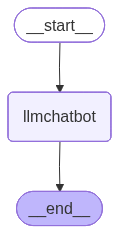

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [17]:
response = graph.invoke({"messages":"Hi"})
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='ead22cd6-acc3-4e7d-8526-374f34e6316d'),
 AIMessage(content="It's nice to meet you. Is there something I can help with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 36, 'total_tokens': 58, 'completion_time': 0.029321574, 'prompt_time': 0.002046984, 'queue_time': 0.054365975, 'total_time': 0.031368558}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c54ae48ece', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f4f68ec3-bd58-47cf-ad14-0c8b2e415049-0', usage_metadata={'input_tokens': 36, 'output_tokens': 22, 'total_tokens': 58})]

In [20]:
for event in graph.stream({"messages":"Hi how are you"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm functioning properly, thank you for asking. How can I assist you today?


In [ ]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
# tool.invoke("what is langgraph")

{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'title': 'What is LangGraph? - GeeksforGeeks',
   'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows.',
   'score': 0.94276565,
   'raw_content': None},
  {'url': 'https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/',
   'title': 'What is LangGraph? - Analytics Vidhya',
   'content': '* LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents. * Langgraph introduces a chat agent executor that represents the agent state as a list of messages, which is particularly useful for newer, chat-based models. The agent executor class in the Langchain framework was the main tool for building and execut

In [38]:
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: _description_
    """
    return a*b

In [39]:
tools = [tool, multiply]

In [40]:
llm_with_tool = llm.bind_tools(tools)

In [41]:
# llm_with_tool.invoke("4*2")

In [63]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")
# builder.add_edge("tool_calling_llm",END)

graph = builder.compile()

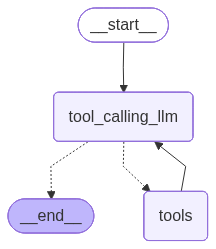

In [64]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [65]:
response = graph.invoke({"messages":"multiply 4 and 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply 4 and 2
================================== Ai Message ==================================
Tool Calls:
  multiply (vtgy848ch)
 Call ID: vtgy848ch
  Args:
    a: 4
    b: 2
================================= Tool Message =================================
Name: multiply

8
================================== Ai Message ==================================

The output of the function is the product of the input parameters, which is 8.


### Adding Memory

In [66]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")
# builder.add_edge("tool_calling_llm",END)

graph = builder.compile(checkpointer=memory)

In [ ]:
config={"configurable":{"thread_id":"1"}}

graph.invoke({"messages":"hi im tutu"}, config=config)

{'messages': [HumanMessage(content='hi im tutu', additional_kwargs={}, response_metadata={}, id='50998754-d268-4020-9ee7-8e36d26f63c0'),
  AIMessage(content='Nice to meet you, Tutu! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 1853, 'total_tokens': 1869, 'completion_time': 0.020659808, 'prompt_time': 0.111531026, 'queue_time': 0.050102244, 'total_time': 0.132190834}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8804b970d6', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f0019b11-8051-425e-9dab-3200c63c4434-0', usage_metadata={'input_tokens': 1853, 'output_tokens': 16, 'total_tokens': 1869})]}

In [69]:
response

{'messages': [HumanMessage(content='multiply 4 and 2', additional_kwargs={}, response_metadata={}, id='093231b4-ecf8-47ed-a698-ec9d894c9cce'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vtgy848ch', 'function': {'arguments': '{"a":4,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1855, 'total_tokens': 1874, 'completion_time': 0.028346228, 'prompt_time': 0.222802249, 'queue_time': 0.056006643, 'total_time': 0.251148477}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c54ae48ece', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b773c709-14c2-4cd3-b323-25d78d445360-0', tool_calls=[{'name': 'multiply', 'args': {'a': 4, 'b': 2}, 'id': 'vtgy848ch', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1855, 'output_tokens': 19, 'total_tokens': 1874}),
  ToolMessage(content='8', name='multiply', id='15033cc6-7319-4310-a37e-8ce735a93f

In [70]:
graph.invoke({"messages":"who am i"},config=config)

{'messages': [HumanMessage(content='hi im tutu', additional_kwargs={}, response_metadata={}, id='50998754-d268-4020-9ee7-8e36d26f63c0'),
  AIMessage(content='Nice to meet you, Tutu! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 1853, 'total_tokens': 1869, 'completion_time': 0.020659808, 'prompt_time': 0.111531026, 'queue_time': 0.050102244, 'total_time': 0.132190834}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8804b970d6', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f0019b11-8051-425e-9dab-3200c63c4434-0', usage_metadata={'input_tokens': 1853, 'output_tokens': 16, 'total_tokens': 1869}),
  HumanMessage(content='who am i', additional_kwargs={}, response_metadata={}, id='4e236271-0a5e-43e6-a8e0-a8beda99e1cf'),
  AIMessage(content='You told me your name is Tutu.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'pro

### Streaming

In [71]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [72]:
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

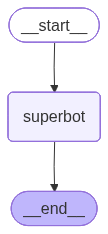

In [75]:
builder = StateGraph(State)
builder.add_node("superbot",superbot)

builder.add_edge(START,"superbot")
builder.add_edge("superbot",END)
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [79]:
config = {"configurable":{"thread_id":"2"}}

graph.invoke({"messages":"im tutu and i like football"},config=config)

{'messages': [HumanMessage(content='im tutu and i like football', additional_kwargs={}, response_metadata={}, id='b096fce2-cdbe-46d1-bfc5-be49e6a03370'),
  AIMessage(content="Nice to meet you, Tutu. It's great that you like football. Which team or league do you enjoy watching the most? Are you a fan of any particular football player or a specific position on the field?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 42, 'total_tokens': 87, 'completion_time': 0.097809886, 'prompt_time': 0.002113283, 'queue_time': 0.055783187, 'total_time': 0.099923169}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8804b970d6', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4c88046f-d91d-4a33-8fc7-95180188837e-0', usage_metadata={'input_tokens': 42, 'output_tokens': 45, 'total_tokens': 87})]}

#### Streaming

In [81]:
config = {"configurable":{"thread_id":"3"}}

for chunk in graph.stream({"messages":"im tutu and i like football"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='im tutu and i like football', additional_kwargs={}, response_metadata={}, id='7895e57f-bdbd-4927-8613-718ca9679228'), AIMessage(content="Nice to meet you, Tutu. It's great to hear that you like football! Which team is your favorite? Are you a fan of a particular league, like the English Premier League or La Liga?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 42, 'total_tokens': 85, 'completion_time': 0.073971678, 'prompt_time': 0.002642457, 'queue_time': 0.048099063, 'total_time': 0.076614135}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8a13dfab2b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6a77b189-c2d3-4d7a-86b6-8446143dd750-0', usage_metadata={'input_tokens': 42, 'output_tokens': 43, 'total_tokens': 85}), HumanMessage(content='im tutu and i like football', additional_kwargs={}, response_metadata={}, id='2e642f92-ef00-4425-ab82-d24a29

In [83]:
config = {"configurable":{"thread_id":"5"}}

for chunk in graph.stream({"messages":"im tutu and i like football"}, config, stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="Nice to meet you, Tutu. It's great that you like football. Which team do you support, or do you have a favorite player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 42, 'total_tokens': 73, 'completion_time': 0.051022601, 'prompt_time': 0.00203214, 'queue_time': 0.05012621, 'total_time': 0.053054741}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8a13dfab2b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--95a75e81-16ac-41f8-a361-4c27d48a7a2b-0', usage_metadata={'input_tokens': 42, 'output_tokens': 31, 'total_tokens': 73})]}}


In [85]:
for chunk in graph.stream({"messages":"i also like football"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='im tutu and i like football', additional_kwargs={}, response_metadata={}, id='cd456afd-aca3-4d65-ace4-a6ec5b01b761'), AIMessage(content="Nice to meet you, Tutu. It's great that you like football. Which team do you support, or do you have a favorite player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 42, 'total_tokens': 73, 'completion_time': 0.051022601, 'prompt_time': 0.00203214, 'queue_time': 0.05012621, 'total_time': 0.053054741}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8a13dfab2b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--95a75e81-16ac-41f8-a361-4c27d48a7a2b-0', usage_metadata={'input_tokens': 42, 'output_tokens': 31, 'total_tokens': 73}), HumanMessage(content='i also like football', additional_kwargs={}, response_metadata={}, id='09a0c93c-f06b-4364-af75-2972c12627a7'), AIMessage(content='It seems like we have a shared interes

In [87]:
config = {"configurable":{"thread_id":"6"}}

async for chunk in graph.astream_events({"messages":"im tutu and i like football"}, config, version="v2"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'im tutu and i like football'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '17f38362-6e72-4bf6-9489-a1005a563339', 'metadata': {'thread_id': '6'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='im tutu and i like football', additional_kwargs={}, response_metadata={}, id='0b0bc265-ac97-4e30-9552-d1096f70f40e')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': 'cc22c172-e291-4ded-8d86-cab27b551cc5', 'metadata': {'thread_id': '6', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:4c107950-8f38-35f8-4e6d-93b8245d0812'}, 'parent_ids': ['17f38362-6e72-4bf6-9489-a1005a563339']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='im tutu and i like football', additional_kwargs={}, response_metadata={}, id=